# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 4

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [4]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [5]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [6]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.419
[2] loss: 0.240
[3] loss: 0.072
[4] loss: 0.038
[5] loss: 0.022
[6] loss: 0.017
[7] loss: 0.011
[8] loss: 0.010
[9] loss: 0.010
[10] loss: 0.007
[11] loss: 0.006
[12] loss: 0.008
[13] loss: 0.005
[14] loss: 0.004
[15] loss: 0.005
[16] loss: 0.003
[17] loss: 0.004
[18] loss: 0.003
[19] loss: 0.004
[20] loss: 0.003


In [7]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 6])

In [8]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

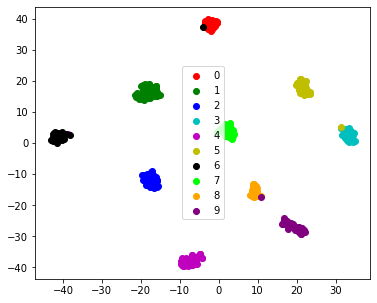

In [9]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

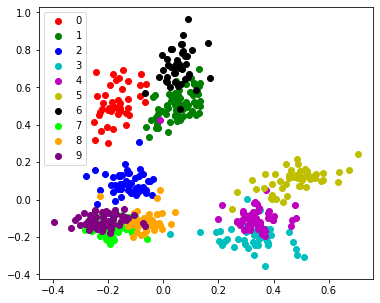

In [10]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [11]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [12]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [13]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1595,  0.0601, -0.1265,  0.3317,  0.3529,  0.4952,  0.0586, -0.1762,
         -0.0751, -0.2276],
        [-0.1709,  0.3621,  0.6181, -0.0647, -0.2427, -0.0119, -0.2121,  0.5214,
         -0.2422, -0.2258],
        [ 0.5144,  0.4902,  0.0686, -0.2067, -0.0896,  0.1221,  0.7101, -0.1489,
         -0.1180, -0.1102],
        [-0.0525, -0.2377,  0.3617, -0.0024, -0.2454, -0.0771,  0.1513, -0.2384,
          0.5424, -0.2100],
        [-0.2652,  0.2465, -0.2058,  0.5677, -0.0416, -0.2569, -0.2293, -0.1626,
          0.0031,  0.4923],
        [ 0.4559, -0.1085, -0.3124, -0.3235,  0.4208, -0.2940, -0.3213,  0.2581,
          0.0887,  0.2295]])

In [14]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [15]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [16]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [18]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_6.cfg')

['./config/sswae_dev2_1_6.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 8
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 4
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.244878e-01  D: 6.910620e-01  D2: 1.991408e-02  D3: 2.560602e-03
test loss: 1.650934e-01  D: 7.124662e-01  D2: 2.544956e-03  D3: 6.782843e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.574054e-01  D: 6.936078e-01  D2: -1.338256e-03  D3: 6.852298e-03
test loss: 1.789147e-01  D: 6.123986e-01  D2: -3.164577e-03  D3: 1.062029e-02


[default |INFO|model.py:1280] [03/80]  loss: 1.379243e-01  D: 6.840051e-01  D2: -4.045132e-03  D3: 7.913584e-03
test loss: 1.139159e-01  D: 6.668328e-01  D2: -4.387369e-03  D3: 5.016377e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.062005e-01  D: 6.865617e-01  D2: -4.376766e-03  D3: 8.391006e-03
test loss: 9.382290e-02  D: 7.115234e-01  D2: -5.049133e-03  D3: 6.691460e-03


[default |INFO|model.py:1280] [05/80]  loss: 9.068386e-02  D: 6.964218e-01  D2: -4.805175e-03  D3: 4.518561e-03
test loss: 8.400691e-02  D: 7.040070e-01  D2: -4.888849e-03  D3: 5.467807e-03


[default |INFO|model.py:1280] [06/80]  loss: 9.040438e-02  D: 6.836288e-01  D2: -4.782920e-03  D3: 7.378533e-03
test loss: 8.752404e-02  D: 6.851185e-01  D2: -4.496231e-03  D3: 6.260355e-03


[default |INFO|model.py:1280] [07/80]  loss: 8.277616e-02  D: 6.906653e-01  D2: -4.791781e-03  D3: 3.889942e-03
test loss: 8.002754e-02  D: 6.923934e-01  D2: -5.814419e-03  D3: 3.399560e-03


[default |INFO|model.py:1280] [08/80]  loss: 8.667314e-02  D: 6.941102e-01  D2: -5.173086e-03  D3: 5.107318e-03
test loss: 7.914249e-02  D: 6.998344e-01  D2: -4.857998e-03  D3: 5.063070e-03


[default |INFO|model.py:1280] [09/80]  loss: 8.809010e-02  D: 6.874770e-01  D2: -5.264223e-03  D3: 8.030985e-03
test loss: 8.482591e-02  D: 7.254006e-01  D2: -5.762243e-03  D3: 1.071415e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.552115e-02  D: 7.042006e-01  D2: -5.361230e-03  D3: 3.960963e-03
test loss: 7.471857e-02  D: 6.945172e-01  D2: -5.226164e-03  D3: 3.616735e-03


[default |INFO|model.py:1280] [11/80]  loss: 8.155139e-02  D: 6.954557e-01  D2: -5.268792e-03  D3: 7.080480e-03
test loss: 7.070104e-02  D: 6.971060e-01  D2: -6.254139e-03  D3: 3.605120e-03


[default |INFO|model.py:1280] [12/80]  loss: 7.482345e-02  D: 6.952516e-01  D2: -5.428562e-03  D3: 4.969156e-03
test loss: 6.965965e-02  D: 6.960217e-01  D2: -5.797224e-03  D3: 2.416994e-03


[default |INFO|model.py:1280] [13/80]  loss: 8.559092e-02  D: 6.961660e-01  D2: -5.443554e-03  D3: 6.316949e-03
test loss: 6.981411e-02  D: 6.974762e-01  D2: -5.658770e-03  D3: 2.641240e-03


[default |INFO|model.py:1280] [14/80]  loss: 7.658100e-02  D: 6.946788e-01  D2: -5.754652e-03  D3: 4.284845e-03
test loss: 7.569112e-02  D: 6.953911e-01  D2: -6.183939e-03  D3: 4.027033e-03


[default |INFO|model.py:1280] [15/80]  loss: 8.338052e-02  D: 6.870696e-01  D2: -5.712431e-03  D3: 7.915264e-03
test loss: 9.390835e-02  D: 6.972284e-01  D2: -5.260696e-03  D3: 1.401378e-02


[default |INFO|model.py:1280] [16/80]  loss: 8.740815e-02  D: 6.991273e-01  D2: -5.322313e-03  D3: 1.444372e-02
test loss: 8.007178e-02  D: 7.349384e-01  D2: -5.655966e-03  D3: 1.157988e-02


[default |INFO|model.py:1280] [17/80]  loss: 7.681534e-02  D: 6.954720e-01  D2: -5.552773e-03  D3: 1.439138e-02
test loss: 7.206629e-02  D: 6.936612e-01  D2: -5.953407e-03  D3: 1.623844e-02


[default |INFO|model.py:1280] [18/80]  loss: 7.482685e-02  D: 6.967372e-01  D2: -5.634370e-03  D3: 1.434179e-02
test loss: 7.578127e-02  D: 6.910412e-01  D2: -5.676985e-03  D3: 1.439778e-02


[default |INFO|model.py:1280] [19/80]  loss: 7.003970e-02  D: 6.953778e-01  D2: -6.136371e-03  D3: 1.388337e-02
test loss: 6.729172e-02  D: 6.850544e-01  D2: -6.059828e-03  D3: 1.429404e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.617042e-02  D: 6.942470e-01  D2: -6.085844e-03  D3: 1.429392e-02
test loss: 6.381546e-02  D: 7.149382e-01  D2: -6.691227e-03  D3: 1.400788e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.330041e-02  D: 6.944155e-01  D2: -6.356815e-03  D3: 1.430818e-02
test loss: 6.086935e-02  D: 7.004921e-01  D2: -7.135687e-03  D3: 1.491965e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.346360e-02  D: 6.938953e-01  D2: -6.289717e-03  D3: 1.425420e-02
test loss: 6.365529e-02  D: 6.925413e-01  D2: -6.217251e-03  D3: 1.224169e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.310254e-02  D: 6.935331e-01  D2: -6.538262e-03  D3: 1.354851e-02
test loss: 6.267778e-02  D: 6.840914e-01  D2: -7.026463e-03  D3: 1.428256e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.235547e-02  D: 6.930985e-01  D2: -6.616896e-03  D3: 1.338766e-02
test loss: 6.796604e-02  D: 6.915481e-01  D2: -6.733646e-03  D3: 1.663148e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.299535e-02  D: 6.943777e-01  D2: -6.812565e-03  D3: 1.314787e-02
test loss: 6.422208e-02  D: 6.863105e-01  D2: -6.992130e-03  D3: 1.448911e-02


[default |INFO|model.py:1280] [26/80]  loss: 6.185067e-02  D: 6.926029e-01  D2: -6.817636e-03  D3: 1.278438e-02
test loss: 6.367068e-02  D: 6.682537e-01  D2: -6.554470e-03  D3: 1.252312e-02


[default |INFO|model.py:1280] [27/80]  loss: 6.071849e-02  D: 6.937449e-01  D2: -6.812565e-03  D3: 1.364228e-02
test loss: 5.981871e-02  D: 6.847421e-01  D2: -7.320385e-03  D3: 1.348623e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.931583e-02  D: 6.956378e-01  D2: -6.968877e-03  D3: 1.328632e-02
test loss: 5.600800e-02  D: 6.843121e-01  D2: -7.603989e-03  D3: 1.177045e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.696904e-02  D: 6.938206e-01  D2: -7.102639e-03  D3: 1.311487e-02
test loss: 5.953187e-02  D: 6.995288e-01  D2: -7.309303e-03  D3: 1.335571e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.719067e-02  D: 6.938274e-01  D2: -7.284430e-03  D3: 1.359565e-02
test loss: 6.002041e-02  D: 7.097252e-01  D2: -6.922722e-03  D3: 1.203580e-02


[default |INFO|model.py:1280] [31/80]  loss: 5.906477e-02  D: 6.934528e-01  D2: -7.099001e-03  D3: 1.327519e-02
test loss: 5.901910e-02  D: 6.785975e-01  D2: -7.089491e-03  D3: 1.370050e-02


[default |INFO|model.py:1280] [32/80]  loss: 5.683463e-02  D: 6.945195e-01  D2: -7.231957e-03  D3: 1.330370e-02
test loss: 5.679435e-02  D: 7.161330e-01  D2: -7.472057e-03  D3: 1.151553e-02


[default |INFO|model.py:1280] [33/80]  loss: 5.576338e-02  D: 6.939197e-01  D2: -7.455859e-03  D3: 1.333565e-02
test loss: 5.727019e-02  D: 7.020017e-01  D2: -7.572756e-03  D3: 1.296314e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.481787e-02  D: 6.944032e-01  D2: -7.613858e-03  D3: 1.310850e-02
test loss: 5.632543e-02  D: 6.975606e-01  D2: -7.352486e-03  D3: 1.391877e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.473572e-02  D: 6.942720e-01  D2: -7.479223e-03  D3: 1.343346e-02
test loss: 5.540269e-02  D: 6.773140e-01  D2: -7.404680e-03  D3: 1.367271e-02


[default |INFO|model.py:1280] [36/80]  loss: 5.446290e-02  D: 6.939899e-01  D2: -7.655724e-03  D3: 1.312325e-02
test loss: 5.545039e-02  D: 6.926560e-01  D2: -7.900105e-03  D3: 1.272797e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.449406e-02  D: 6.940189e-01  D2: -7.843132e-03  D3: 1.295826e-02
test loss: 5.457949e-02  D: 7.057190e-01  D2: -7.505417e-03  D3: 1.392880e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.585765e-02  D: 6.942038e-01  D2: -7.827306e-03  D3: 1.322984e-02
test loss: 5.628881e-02  D: 6.829424e-01  D2: -8.002224e-03  D3: 1.356646e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.438462e-02  D: 6.939129e-01  D2: -7.920858e-03  D3: 1.278432e-02
test loss: 5.475210e-02  D: 7.224470e-01  D2: -8.084269e-03  D3: 1.322193e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.398827e-02  D: 6.945467e-01  D2: -7.956595e-03  D3: 1.274656e-02
test loss: 5.372451e-02  D: 6.978081e-01  D2: -8.307095e-03  D3: 1.268055e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.319625e-02  D: 6.938278e-01  D2: -8.088487e-03  D3: 1.262736e-02
test loss: 5.538329e-02  D: 6.999039e-01  D2: -7.945995e-03  D3: 1.334198e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.329311e-02  D: 6.946724e-01  D2: -8.159021e-03  D3: 1.264291e-02
test loss: 5.432914e-02  D: 6.843604e-01  D2: -8.025360e-03  D3: 1.388526e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.438212e-02  D: 6.936387e-01  D2: -8.133311e-03  D3: 1.290122e-02
test loss: 5.275800e-02  D: 7.135872e-01  D2: -7.860632e-03  D3: 1.220214e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.340017e-02  D: 6.942785e-01  D2: -8.253303e-03  D3: 1.254943e-02
test loss: 5.775080e-02  D: 6.921485e-01  D2: -7.787123e-03  D3: 1.199369e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.279158e-02  D: 6.946650e-01  D2: -8.261255e-03  D3: 1.255705e-02
test loss: 5.601646e-02  D: 6.978003e-01  D2: -8.646154e-03  D3: 1.265934e-02


[default |INFO|model.py:1280] [46/80]  loss: 5.295537e-02  D: 6.932822e-01  D2: -8.387106e-03  D3: 1.267537e-02
test loss: 5.314296e-02  D: 6.991068e-01  D2: -8.642969e-03  D3: 1.153090e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.250778e-02  D: 6.945209e-01  D2: -8.451616e-03  D3: 1.242911e-02
test loss: 5.104218e-02  D: 6.949017e-01  D2: -7.947292e-03  D3: 1.267198e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.218963e-02  D: 6.945572e-01  D2: -8.439506e-03  D3: 1.239192e-02
test loss: 5.322059e-02  D: 6.916344e-01  D2: -8.765612e-03  D3: 1.260445e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.181811e-02  D: 6.935022e-01  D2: -8.532406e-03  D3: 1.256134e-02
test loss: 5.488352e-02  D: 7.017289e-01  D2: -8.655939e-03  D3: 1.212846e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.256710e-02  D: 6.938992e-01  D2: -8.650160e-03  D3: 1.199807e-02
test loss: 5.449812e-02  D: 7.000979e-01  D2: -8.656578e-03  D3: 1.342891e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.269776e-02  D: 6.937092e-01  D2: -8.699910e-03  D3: 1.225319e-02
test loss: 5.513011e-02  D: 6.958114e-01  D2: -8.464937e-03  D3: 1.241863e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.195781e-02  D: 6.939077e-01  D2: -8.675400e-03  D3: 1.225577e-02
test loss: 5.211325e-02  D: 6.708917e-01  D2: -8.244410e-03  D3: 1.127284e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.071491e-02  D: 6.942945e-01  D2: -8.783995e-03  D3: 1.215466e-02
test loss: 5.158348e-02  D: 6.950514e-01  D2: -8.953266e-03  D3: 1.208919e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.069731e-02  D: 6.937312e-01  D2: -8.835721e-03  D3: 1.216395e-02
test loss: 5.201387e-02  D: 6.894040e-01  D2: -8.951731e-03  D3: 1.214240e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.140510e-02  D: 6.944956e-01  D2: -8.849355e-03  D3: 1.189794e-02
test loss: 5.477569e-02  D: 6.944949e-01  D2: -8.986464e-03  D3: 1.243299e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.344800e-02  D: 6.944123e-01  D2: -8.903422e-03  D3: 1.169815e-02
test loss: 5.712621e-02  D: 6.899886e-01  D2: -8.831196e-03  D3: 1.189535e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.181129e-02  D: 6.928144e-01  D2: -8.897746e-03  D3: 1.198879e-02
test loss: 5.307858e-02  D: 6.877004e-01  D2: -8.867970e-03  D3: 1.204951e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.054588e-02  D: 6.935734e-01  D2: -8.980772e-03  D3: 1.223788e-02
test loss: 5.318308e-02  D: 6.864309e-01  D2: -9.038506e-03  D3: 1.080955e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.088085e-02  D: 6.927150e-01  D2: -8.957011e-03  D3: 1.202936e-02
test loss: 5.262881e-02  D: 6.840192e-01  D2: -9.303141e-03  D3: 1.189698e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.106926e-02  D: 6.936136e-01  D2: -9.021560e-03  D3: 1.184379e-02
test loss: 5.342791e-02  D: 7.019970e-01  D2: -8.754129e-03  D3: 1.113910e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.025585e-02  D: 6.937233e-01  D2: -9.109877e-03  D3: 1.151276e-02
test loss: 5.442253e-02  D: 6.916617e-01  D2: -8.863697e-03  D3: 1.075388e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.068463e-02  D: 6.939607e-01  D2: -9.077837e-03  D3: 1.163597e-02
test loss: 5.434389e-02  D: 6.953213e-01  D2: -8.797379e-03  D3: 1.120296e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.047500e-02  D: 6.947294e-01  D2: -9.121404e-03  D3: 1.161659e-02
test loss: 5.308782e-02  D: 6.817949e-01  D2: -9.196453e-03  D3: 1.159924e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.001575e-02  D: 6.933265e-01  D2: -9.138870e-03  D3: 1.186523e-02
test loss: 5.006636e-02  D: 6.851774e-01  D2: -9.343348e-03  D3: 1.204829e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.950671e-02  D: 6.938723e-01  D2: -9.181385e-03  D3: 1.181819e-02
test loss: 5.162872e-02  D: 6.969337e-01  D2: -9.011707e-03  D3: 1.187463e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.926771e-02  D: 6.935474e-01  D2: -9.209574e-03  D3: 1.176466e-02
test loss: 5.230907e-02  D: 6.788897e-01  D2: -9.282246e-03  D3: 1.135805e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.906951e-02  D: 6.935150e-01  D2: -9.257075e-03  D3: 1.179500e-02
test loss: 4.995775e-02  D: 6.974502e-01  D2: -9.572172e-03  D3: 1.231718e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.001436e-02  D: 6.939212e-01  D2: -9.204704e-03  D3: 1.178196e-02
test loss: 5.435056e-02  D: 6.907976e-01  D2: -8.734312e-03  D3: 1.314200e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.844600e-02  D: 6.936639e-01  D2: -9.287717e-03  D3: 1.187682e-02
test loss: 4.954647e-02  D: 6.806716e-01  D2: -9.295816e-03  D3: 1.175453e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.847616e-02  D: 6.934546e-01  D2: -9.287793e-03  D3: 1.184574e-02
test loss: 5.232404e-02  D: 6.853028e-01  D2: -9.421091e-03  D3: 1.325160e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.940511e-02  D: 6.935857e-01  D2: -9.245990e-03  D3: 1.166632e-02
test loss: 5.127124e-02  D: 6.921803e-01  D2: -9.422293e-03  D3: 1.280678e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.870214e-02  D: 6.941586e-01  D2: -9.344614e-03  D3: 1.165458e-02
test loss: 5.060333e-02  D: 6.903717e-01  D2: -9.408407e-03  D3: 1.092089e-02


[default |INFO|model.py:1280] [73/80]  loss: 4.875873e-02  D: 6.939409e-01  D2: -9.296802e-03  D3: 1.160403e-02
test loss: 4.958727e-02  D: 6.929866e-01  D2: -9.528856e-03  D3: 1.142032e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.820396e-02  D: 6.938700e-01  D2: -9.332689e-03  D3: 1.170358e-02
test loss: 4.944268e-02  D: 6.875969e-01  D2: -9.332666e-03  D3: 1.181319e-02


[default |INFO|model.py:1280] [75/80]  loss: 4.794089e-02  D: 6.928479e-01  D2: -9.315996e-03  D3: 1.178679e-02
test loss: 5.055468e-02  D: 6.988805e-01  D2: -9.384937e-03  D3: 1.237219e-02


[default |INFO|model.py:1280] [76/80]  loss: 4.906144e-02  D: 6.943146e-01  D2: -9.366008e-03  D3: 1.156245e-02
test loss: 5.157841e-02  D: 6.823906e-01  D2: -9.350452e-03  D3: 1.151735e-02


[default |INFO|model.py:1280] [77/80]  loss: 4.773948e-02  D: 6.938702e-01  D2: -9.392180e-03  D3: 1.178964e-02
test loss: 4.912893e-02  D: 6.868692e-01  D2: -9.427729e-03  D3: 1.160346e-02


[default |INFO|model.py:1280] [78/80]  loss: 4.766435e-02  D: 6.937466e-01  D2: -9.380943e-03  D3: 1.167749e-02
test loss: 5.094431e-02  D: 6.889430e-01  D2: -9.011660e-03  D3: 1.027673e-02


[default |INFO|model.py:1280] [79/80]  loss: 4.743692e-02  D: 6.929217e-01  D2: -9.363964e-03  D3: 1.144310e-02
test loss: 4.922835e-02  D: 6.883963e-01  D2: -9.484739e-03  D3: 1.097157e-02


[default |INFO|model.py:1280] [80/80]  loss: 4.752035e-02  D: 6.941571e-01  D2: -9.452840e-03  D3: 1.133281e-02
test loss: 4.969182e-02  D: 6.934148e-01  D2: -9.619122e-03  D3: 1.195676e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3186.768s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

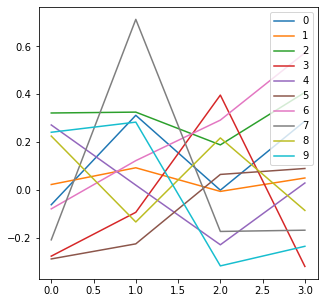

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

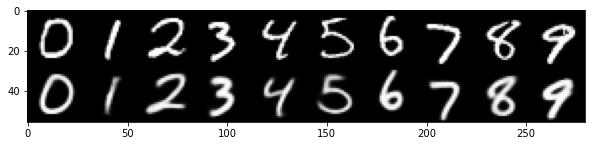

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

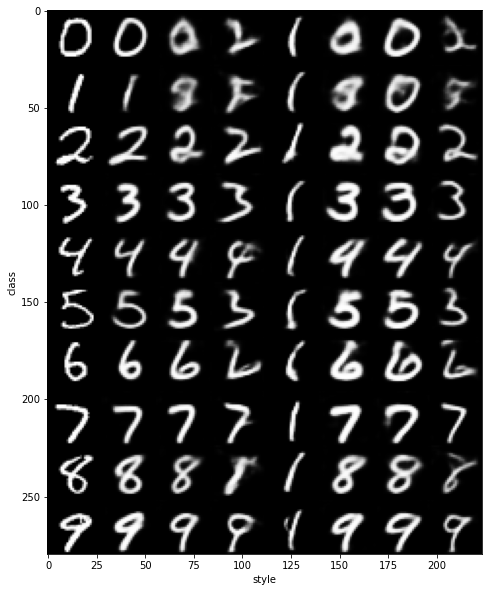

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

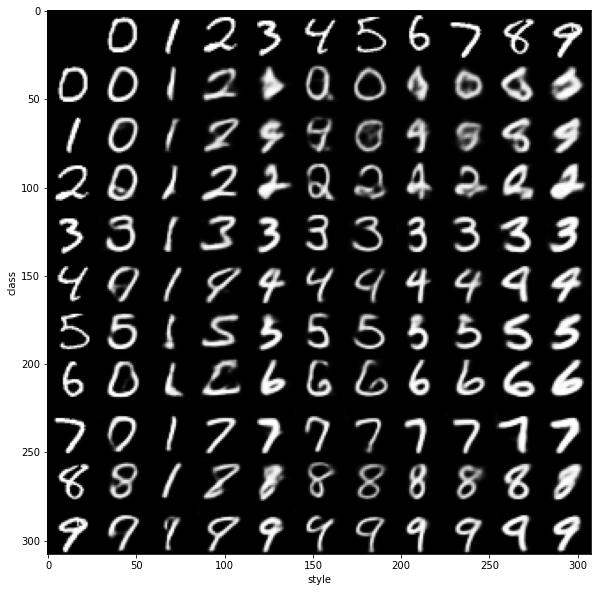

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()